## Import Libraries

In [28]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext.legacy import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [30]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

## Load Dataset and Process

In [31]:
with open("All_Tickers_PN.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

# we will use the Neutrals in the end (All Neutrals)
# *************************************
Xnew_Neutrals=X[X['Target']=='Neutral']
Xnew_Neutrals=Xnew_Neutrals.sort_values("Date")
Xnew_Neutrals.drop_duplicates(inplace=True)
Xnew_Neutrals.index = range(len(Xnew_Neutrals))
Xnew_Neutrals['Article']=clean_data(Xnew_Neutrals['Article'])
Xnew_Neutrals['Target']=target_arrange(Xnew_Neutrals['Target'])
Xnew_Neutrals=Xnew_Neutrals.drop('Date',1)
# *******************************************

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())


Number of Examples :  133743 

Number of Examples after removing duplicates:  74595 

Number of words before cleaning :  2635769
Number of words after cleaning :  1717037

******************

Negative Examples :  37278
Positive Examples :  37317


## Stemming

In [32]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()


# Stemming for Neutrals
#**********************************************************************************************************
Xnew_Neutrals['Article']= Xnew_Neutrals['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(Xnew_Neutrals['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    Xnew_Neutrals['Article'][i] = ' '.join(Xnew_Neutrals['Article'][i])
Xnew_Neutrals['Article'] = Xnew_Neutrals['Article'].to_frame()
Xnew_Neutrals.to_csv (r'All_Neutrals.csv', index = False, header=True)
#*************************************************************************************************************

0        com stock problem beyond china trade war com s...
1        adob share fall disappoint guidanc share adob ...
2        first solar stock drop solar power grow solar ...
3        mobil sprint merger oppos attorney gener penns...
4        pennsylvania join state oppos merger mobil spr...
                               ...                        
74590    emerg biosolut slip friday profit came estim c...
74591    aftermath elect market labor market nov sharmi...
74592    weekli high frequenc indic slow improv continu...
74593    alibaba user growth core commerc earn concern ...
74594    nouriel roubini discuss economi stimulu elect ...
Name: Article, Length: 74595, dtype: object


## Oversampling and Csvs

In [33]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.2,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train1=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])

df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train1['Article']=df['Article']
train1['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Negative Examples in Training after OverSampling: ",(train1['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train1['Target']==1).sum())

train1.to_csv (r'Train_General.csv', index = False, header=True)
test.to_csv (r'Test_General.csv', index = False, header=True)
val.to_csv (r'Val_General.csv', index = False, header=True)




Negative Examples in Training after OverSampling:  26868
Positive Examples in Training after OverSampling:  26868


## Build Vocabulary

In [34]:

torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train_General.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_General.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_General.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 23344
Size of LABEL vocabulary: 2
[('stock', 29960), ('earn', 18201), ('market', 14207), ('report', 11954), ('compani', 8292), ('coronaviru', 8289), ('expect', 7476), ('trade', 7302), ('investor', 7023), ('share', 6663)]


## Accuracy, Loss and Optimizer Function

In [35]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [36]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    print("\n")
    print(metrics.classification_report(yt, yp, digits=3))
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [37]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [38]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=12
dropout = 0.5

train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(23344, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(23344, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## LSTM results

Epoch :  5  Train Loss :  0.19422965941038906   Train Acc :  0.9210771328107008   Valid Loss :  0.2711955632544104  Val Acc :  0.9067938589906118
Epoch :  10  Train Loss :  0.15490433373698023   Train Acc :  0.9380489926803532   Valid Loss :  0.32387577780290044  Val Acc :  0.898761731793124
Epoch :  15  Train Loss :  0.13555869175837254   Train Acc :  0.9463302180829886   Valid Loss :  0.3563076773643551  Val Acc :  0.9006024275917605
Epoch :  20  Train Loss :  0.1252970571667191   Train Acc :  0.9499776793836003   Valid Loss :  0.3601576761982168  Val Acc :  0.8965863632150444
Epoch :  25  Train Loss :  0.11820380000213815   Train Acc :  0.952006114319852   Valid Loss :  0.3959732295968196  Val Acc :  0.8940763246103463
Epoch :  30  Train Loss :  0.11148690455650362   Train Acc :  0.9545556150040705   Valid Loss :  0.3866133086894004  Val Acc :  0.8975903785611731

Time needed for Training :  22.253385162353517

Loss in Testset :  0.26840712923425175   Accuracy in Testset :  0.904608

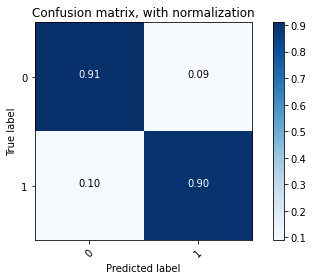

In [39]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_Gen_PN.pt")

## GRU results

Epoch :  5  Train Loss :  0.2230992252031044   Train Acc :  0.911158271563165   Valid Loss :  0.2460447903385902  Val Acc :  0.9032798027657122
Epoch :  10  Train Loss :  0.2037587437855455   Train Acc :  0.9197558583878895   Valid Loss :  0.26984376746723543  Val Acc :  0.8995984109290632
Epoch :  15  Train Loss :  0.20846011721888452   Train Acc :  0.9194581066193779   Valid Loss :  0.2709149790172237  Val Acc :  0.9036144744679631
Epoch :  20  Train Loss :  0.2172420462071413   Train Acc :  0.9147499035436588   Valid Loss :  0.2756375305543478  Val Acc :  0.9017737784299505
Epoch :  25  Train Loss :  0.22620780392378975   Train Acc :  0.9111768804314202   Valid Loss :  0.27681371660147563  Val Acc :  0.8977577148910507
Epoch :  30  Train Loss :  0.23212624969029097   Train Acc :  0.908441284595722   Valid Loss :  0.2825298732722619  Val Acc :  0.8942436596236555

Time needed for Training :  20.75649758974711

Loss in Testset :  0.2591740906334383   Accuracy in Testset :  0.899986619

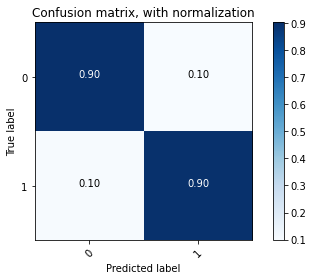

In [40]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_Gen_PN.pt")

## Evaluate Semantic Neutrals as Positive-Negative

In [41]:
def sentence(model, s):
    model.eval()
    
    token = [tok.text for tok in lang.tokenizer(s)]
    index = [TEXT.vocab.stoi[t] for t in token]
    tensor = torch.LongTensor(index).to(device)
    tensor = tensor.unsqueeze(0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()

In [42]:
# LSTM
Neutral_pd = pd.read_csv("All_Neutrals.csv")
train_pd = pd.read_csv("Train_General.csv")


for index, row in Neutral_pd.iterrows():
    st=str(Neutral_pd['Article'][index])
    v=sentence(new_model2,st)
    if v>0.9:
      Neutral_pd['Target'][index]=1.0
    elif v<0.2:
      Neutral_pd['Target'][index]=0.0
    else:
      Neutral_pd['Target'][index]=2.0


#Delete these examples that are not classified as Positive or Negative
indexNames = Neutral_pd[Neutral_pd['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame
Neutral_pd.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by LSTM : ",len(Neutral_pd))

# GRU
Neutral_pd2 = pd.read_csv("All_Neutrals.csv")
for index, row in Neutral_pd2.iterrows():
    v=sentence(new_model3,str(Neutral_pd2['Article'][index]))
    if v>0.9:
      Neutral_pd2['Target'][index]=1.0
    elif v<0.2:
      Neutral_pd2['Target'][index]=0.0
    else:
      Neutral_pd2['Target'][index]=2.0

#Delete these examples that are not classified as Positive or Negative
indexNames = Neutral_pd2[Neutral_pd2['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame
Neutral_pd2.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by GRU : ",len(Neutral_pd2))

Neutral_pd=Neutral_pd.merge(Neutral_pd2)

print("\nNumber of Neutrals that might be not Neutrals that agree LSTM and GRU : ",len(Neutral_pd))



Number of Neutrals that might be not Neutrals by LSTM :  30166

Number of Neutrals that might be not Neutrals by GRU :  25913

Number of Neutrals that might be not Neutrals that agree LSTM and GRU :  23259


In [43]:
count1=(Neutral_pd['Target']==0).sum()
count2=(Neutral_pd['Target']==1).sum()

if count2>count1:
  count3=count2//count1-1
  count4=count2%count1
  Xnew=Neutral_pd[Neutral_pd['Target']==0]
else:
  count3=count1//count2-1
  count4=count1%count2
  Xnew=Neutral_pd[Neutral_pd['Target']==1]

for i in range(count3):
  Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)

Xnew=Xnew.head(count4)

Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)
Neutral_pd = pd.concat([train_pd,Neutral_pd], ignore_index=True)
print("Negative Examples in Training after OverSampling: ",(Neutral_pd ['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(Neutral_pd ['Target']==1).sum())
Neutral_pd = Neutral_pd.sample(frac=1).reset_index(drop=True)

Neutral_pd.to_csv (r'General_train_with_Neutrals.csv', index = False, header=True)

Negative Examples in Training after OverSampling:  41529
Positive Examples in Training after OverSampling:  41529


## Retrain Models with new examples from Semantic Neutrals

In [44]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General_train_with_Neutrals.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_General.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_General.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=12
dropout = 0.5

train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)



new_model4 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model4.to(torch.device(device))
new_model5 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model5.to(torch.device(device))


myGRU(
  (embedding): Embedding(33782, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## LSTM results after learning "Neutrals"

Epoch :  5  Train Loss :  0.14370552527996872   Train Acc :  0.9464027849589769   Valid Loss :  0.292378738461283  Val Acc :  0.9051204998809171
Epoch :  10  Train Loss :  0.11634789354956768   Train Acc :  0.9555041990298062   Valid Loss :  0.34718403538542214  Val Acc :  0.903447139574342
Epoch :  15  Train Loss :  0.10698280252231274   Train Acc :  0.9595492721482255   Valid Loss :  0.3653005227856172  Val Acc :  0.9041164826197796
Epoch :  20  Train Loss :  0.10113612402791074   Train Acc :  0.9615116139792597   Valid Loss :  0.37421618618471286  Val Acc :  0.9027777958107761

Time needed for Training :  27.63429508606593

Loss in Testset :  0.3151026076330823   Accuracy in Testset :  0.9055466397973886 

Normalized confusion matrix
[[0.899 0.101]
 [0.088 0.912]]


              precision    recall  f1-score   support

         0.0      0.911     0.899     0.905      7456
         1.0      0.901     0.912     0.906      7463

    accuracy                          0.905     14919
  

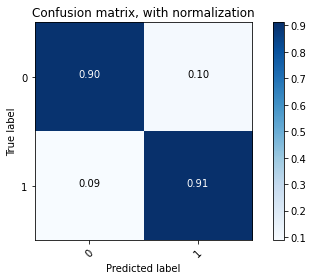

In [45]:
lstm_list2=process_test(new_model4,20,train_it,val_it,test_it,0.001,"LSTM_Gen_PN2.pt")

## GRU results after learning "Neutrals"

Epoch :  5  Train Loss :  0.16960027043050954   Train Acc :  0.9367957364372765   Valid Loss :  0.26399979791435674  Val Acc :  0.9009370996530754
Epoch :  10  Train Loss :  0.16796585276026435   Train Acc :  0.9381802108152792   Valid Loss :  0.2993457717002822  Val Acc :  0.8944109966716614
Epoch :  15  Train Loss :  0.17015188161787065   Train Acc :  0.9372050593747324   Valid Loss :  0.29474561807258154  Val Acc :  0.8947456674164079
Epoch :  20  Train Loss :  0.17247050702351888   Train Acc :  0.935278833945753   Valid Loss :  0.30950984302683765  Val Acc :  0.89725570638017

Time needed for Training :  25.733226450284324

Loss in Testset :  0.2734116907340064   Accuracy in Testset :  0.9002545720319656 

Normalized confusion matrix
[[0.903 0.097]
 [0.102 0.898]]


              precision    recall  f1-score   support

         0.0      0.898     0.903     0.901      7456
         1.0      0.902     0.898     0.900      7463

    accuracy                          0.900     14919
 

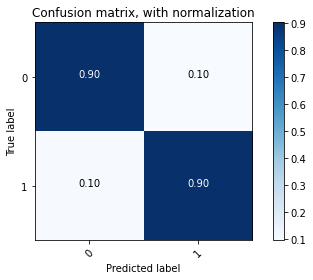

In [46]:
gru_list2=process_test(new_model5,20,train_it,val_it,test_it,0.001,"GRU_Gen_PN2.pt")